# 3. Proper Motion

In the previous lesson, we wrote a query to select stars from the region of the sky where we expect GD-1 to be, and saved the results in a FITS file.

Now we'll read that data back and implement the next step in the analysis, identifying stars with the proper motion we expect for GD-1.

## Outline

Here are the steps in this lesson:

1. We'll read back the results from the previous lesson, which we saved in a FITS file.

2. Then we'll transform the coordinates and proper motion data from ICRS back to the coordinate frame of GD-1.

3. We'll put those results into a Pandas `DataFrame`, which we'll use to select stars near the centerline of GD-1.

4. Plotting the proper motion of those stars, we'll identify a region of proper motion for stars that are likely to be in GD-1.

5. Finally, we'll select and plot the stars whose proper motion is in that region.

After completing this lesson, you should be able to

* Select rows and columns from an Astropy `Table`.

* Use Matplotlib to make a scatter plot.

* Use Gala to transform coordinates.

* Make a Pandas `DataFrame` and use a Boolean `Series` to select rows.

* Save a `DataFrame` in an HDF5 file.


## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install the libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  See the instructions in the preface.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala wget

## Reload the data

In the previous lesson, we ran a query on the Gaia server and downloaded data for roughly 100,000 stars.  We saved the data in a FITS file so that now, picking up where we left off, we can read the data from a local file rather than running the query again.

If you ran the previous lesson successfully, you should already have a file called `gd1_results.fits` that contains the data we downloaded.

If not, you can run the following cell, which downloads the data from our repository.

In [14]:
import os
from wget import download

filename = 'gd1_results.fits'
path = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(path+filename))

Now here's how we can read the data from the file back into an Astropy `Table`:

In [15]:
from astropy.table import Table

results = Table.read(filename)

The result is an Astropy `Table`.

We can use `info` to refresh our memory of the contents.

In [16]:
results.info

<Table length=140339>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
 parallax float64      mas                                                           Parallax

## Selecting rows and columns

In this section we'll see operations for selecting columns and rows from an Astropy `Table`.  You can find more information about these operations in the [Astropy documentation](https://docs.astropy.org/en/stable/table/access_table.html).

We can get the names of the columns like this:

In [17]:
results.colnames

['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'parallax']

And select an individual column like this:

In [18]:
results['ra']

142.48301935991023
142.25452941346344
142.64528557468074
142.57739430926034
142.58913564478618
141.81762228999614
143.18339801317677
142.9347319464589
142.26769745823267
142.89551292869012
142.2780935768316


The result is a `Column` object that contains the data, and also the data type, units, and name of the column.

In [19]:
type(results['ra'])

astropy.table.column.Column

The rows in the `Table` are numbered from 0 to `n-1`, where `n` is the number of rows.  We can select the first row like this:

In [20]:
results[0]

source_id,ra,dec,pmra,pmdec,parallax
,deg,deg,mas / yr,mas / yr,mas
int64,float64,float64,float64,float64,float64
637987125186749568,142.48301935991023,21.75771616932985,-2.5168384683875766,2.941813096629439,-0.2573448962333354


As you might have guessed, the result is a `Row` object.

In [21]:
type(results[0])

astropy.table.row.Row

Notice that the bracket operator selects both columns and rows.  You might wonder how it knows which to select.

If the expression in brackets is a string, it selects a column; if the expression is an integer, it selects a row.

If you apply the bracket operator twice, you can select a column and then an element from the column.

In [22]:
results['ra'][0]

142.48301935991023

Or you can select a row and then an element from the row.

In [23]:
results[0]['ra']

142.48301935991023

You get the same result either way.

## Scatter plot

To see what the results look like, we'll use a scatter plot.  The library we'll use is [Matplotlib](https://matplotlib.org/), which is the most widely-used plotting library for Python.

The Matplotlib interface is based on MATLAB (hence the name), so if you know MATLAB, some of it will be familiar.

We'll import like this.

In [24]:
import matplotlib.pyplot as plt

Pyplot is part of the Matplotlib library.  It is conventional to import it using the shortened name `plt`.

In recent versions of Jupyter, plots appear "inline"; that is, they are part of the notebook.  In some older versions, plots might appear in a new window.
In that case, you might want to run the following Jupyter [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib) in a notebook cell:

```
%matplotlib inline
```

Pyplot provides two functions that can make scatterplots, [plt.scatter](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.scatter.html) and [plt.plot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html).

* `scatter` is more versatile; for example, you can make every point in a scatter plot a different color.

* `plot` is more limited, but for simple cases, it can be substantially faster.  

Jake Vanderplas explains these differences in [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html)

Since we are plotting more than 100,000 points and they are all the same size and color, we'll use `plot`.

Here's a scatter plot with right ascension on the x-axis and declination on the y-axis, both ICRS coordinates in degrees.

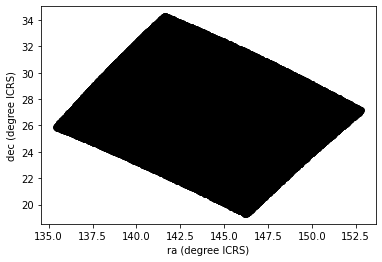

In [25]:
x = results['ra']
y = results['dec']
plt.plot(x, y, 'ko')

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

The arguments to `plt.plot` are `x`, `y`, and a string that specifies the style.  In this case, the letters `ko` indicate that we want a black, round marker (`k` is for black because `b` is for blue).

The functions `xlabel` and `ylabel` put labels on the axes.

This scatter plot has a problem.  It is "[overplotted](https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/)", which means that there are so many overlapping points, we can't distinguish between high and low density areas.

To fix this, we can provide optional arguments to control the size and transparency of the points.

### Exercise

In the call to `plt.plot`, use the keyword argument `markersize` to make the markers smaller.

Then add the keyword argument `alpha` to make the markers partly transparent.

Adjust these arguments until you think the figure shows the data most clearly.

Note: Once you have made these changes, you might notice that the figure shows stripes with lower density of stars.  These stripes are caused by the way Gaia scans the sky, which [you can read about here](https://www.cosmos.esa.int/web/gaia/scanning-law).  The dataset we are using, [Gaia Data Release 2](https://www.cosmos.esa.int/web/gaia/dr2), covers 22 months of observations; during this time, some parts of the sky were scanned more than others.

In [26]:
# Solution

# x = results['ra']
# y = results['dec']
# plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)

# plt.xlabel('ra (degree ICRS)')
# plt.ylabel('dec (degree ICRS)');

## Transform back

Remember that we selected data from a rectangle of coordinates in the `GD1Koposov10` frame, then transformed them to ICRS when we constructed the query.
The coordinates in `results` are in ICRS.

To plot them, we will transform them back to the `GD1Koposov10` frame; that way, the axes of the figure are aligned with the orbit of GD-1, which is useful for two reasons:

* We can identify stars that are likely to be in GD-1 by selecting stars near the centerline of the stream, where $\phi_2$ is close to 0.

* We expect stars in GD-1 to have similar non-zero proper motion along the $\phi_1$ axis.

To do the transformation, we'll put the results into a `SkyCoord` object.  In a previous lesson we created a `SkyCoord` object like this:

In [27]:
from astropy.coordinates import SkyCoord

skycoord = SkyCoord(ra=results['ra'], dec=results['dec'])

Now we're going to do something similar, but in addition to `ra` and `dec`, we'll also include:

* `pmra` and `pmdec`, which are proper motion in the ICRS frame, and

* `distance` and `radial_velocity`, which we explain below.

In [28]:
import astropy.units as u

distance = 8 * u.kpc
radial_velocity= 0 * u.km/u.s

skycoord = SkyCoord(ra=results['ra'], 
                    dec=results['dec'],
                    pm_ra_cosdec=results['pmra'],
                    pm_dec=results['pmdec'], 
                    distance=distance, 
                    radial_velocity=radial_velocity)

For the first four arguments, we use columns from `results`.

For `distance` and `radial_velocity` we use constants, which we explain below.

The result is an Astropy `SkyCoord` object, which we can transform to the GD-1 frame.

In [29]:
from gala.coordinates import GD1Koposov10

gd1_frame = GD1Koposov10()
transformed = skycoord.transform_to(gd1_frame)

The result is another `SkyCoord` object, now in the `GD1Koposov10` frame.

## Reflex Correction

The next step is to correct the proper motion measurements for the effect of the motion of our solar system around the Galactic center.

When we created `skycoord`, we provided constant values for `distance` and `radial_velocity` rather than measurements from Gaia.

That might seem like a strange thing to do, but here's the motivation:

* Because the stars in GD-1 are so far away, the distance estimates we get from Gaia, which are based on parallax, are not very precise.  So we replace them with our current best estimate of the mean distance to GD-1, about 8 kpc.  See [Koposov, Rix, and Hogg, 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..260K/abstract).

* For the other stars in the table, this distance estimate will be inaccurate, so reflex correction will not be correct.  But that should have only a small effect on our ability to identify stars with the proper motion we expect for GD-1.

* The measurement of radial velocity has no effect on the correction for proper motion, but we have to provide a value to avoid errors in the reflex correction calculation.  So we provide `0` as an arbitrary place-keeper.

With this preparation, we can use `reflex_correct` from Gala ([documentation here](https://gala-astro.readthedocs.io/en/latest/api/gala.coordinates.reflex_correct.html)) to correct for the motion of the solar system.

In [30]:
from gala.coordinates import reflex_correct

skycoord_gd1 = reflex_correct(transformed)

The result is a `SkyCoord` object that contains 

* `phi1` and `phi2`, which represent the transformed coordinates in the `GD1Koposov10` frame.

* `pm_phi1_cosphi2` and `pm_phi2`, which represent the transformed and corrected proper motions.

We can select the coordinates and plot them like this:

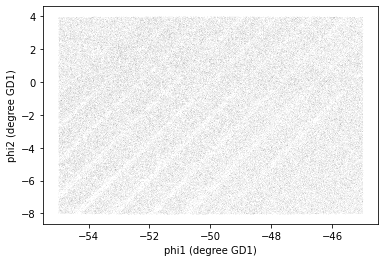

In [31]:
x = skycoord_gd1.phi1
y = skycoord_gd1.phi2
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)');

Remember that we started with a rectangle in the GD-1 frame.  When transformed to the ICRS frame, it's a non-rectangular polygon.  Now, transformed back to the GD-1 frame, it's a rectangle again.

## Pandas DataFrame

At this point we have two objects containing different subsets of the data.  `results` is the Astropy `Table` we downloaded from Gaia.

In [32]:
type(results)

astropy.table.table.Table

And `skycoord_gd1` is a `SkyCoord` object that contains the transformed coordinates and proper motions.

In [33]:
type(skycoord_gd1)

astropy.coordinates.sky_coordinate.SkyCoord

On one hand, this division of labor makes sense because each object provides different capabilities.  But working with multiple object types can be awkward.

It will be more convenient to choose one object and get all of the data into it.  We'll use a Pandas DataFrame, for two reasons:

1. It provides capabilities that (almost) a superset of the other data structures, so it's the all-in-one solution.

2. Pandas is a general-purpose tool that is useful in many domains, especially data science.  If you are going to develop expertise in one tool, Pandas is a good choice.

However, compared to an Astropy `Table`, Pandas has one big drawback: it does not keep the metadata associated with the table, including the units for the columns.

It's easy to convert a `Table` to a Pandas `DataFrame`.

In [34]:
import pandas as pd

results_df = results.to_pandas()
results_df.shape

(140339, 6)

`DataFrame` provides `shape`, which shows the number of rows and columns.

It also provides `head`, which displays the first few rows.  It is useful for spot-checking large results as you go along.

In [35]:
results_df.head()

,source_id,ra,dec,pmra,pmdec,parallax
0,637987125186749568,142.483019,21.757716,-2.516838,2.941813,-0.257345
1,638285195917112960,142.254529,22.476168,2.662702,-12.165984,0.422728
2,638073505568978688,142.645286,22.166932,18.306747,-7.950660,0.103640
3,638086386175786752,142.577394,22.227920,0.987786,-2.584105,-0.857327
4,638049655615392384,142.589136,22.110783,0.244439,-4.941079,0.099625


**Python detail:** `shape` is an attribute, so we display its value without calling it as a function; `head` is a function, so we need the parentheses.

Now we can extract the columns we want from `skycoord_gd1` and add them as columns in the `DataFrame`.  `phi1` and `phi2` contain the transformed coordinates.

In [36]:
results_df['phi1'] = skycoord_gd1.phi1
results_df['phi2'] = skycoord_gd1.phi2
results_df.shape

(140339, 8)

`pm_phi1_cosphi2` and `pm_phi2` contain the components of proper motion in the transformed frame.

In [37]:
results_df['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
results_df['pm_phi2'] = skycoord_gd1.pm_phi2
results_df.shape

(140339, 10)

**Detail:** If you notice that `SkyCoord` has an attribute called `proper_motion`, you might wonder why we are not using it.

We could have: `proper_motion` contains the same data as `pm_phi1_cosphi2` and `pm_phi2`, but in a different format.

## Exploring data

One benefit of using Pandas is that it provides functions for exploring the data and checking for problems.

One of the most useful of these functions is `describe`, which computes summary statistics for each column.

In [39]:
results_df.describe()

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2
count,1.403400e+05,140340.000000,140340.000000,140340.000000,140340.000000,140340.000000,140340.000000,1.403400e+05,140340.000000,140340.000000,140340.000000,140340.000000
mean,6.792378e+17,143.822971,26.780161,-2.484410,-6.100784,0.179474,0.518068,9.931167e+19,-50.091337,-1.803264,-0.868980,1.409215
std,3.792015e+16,3.697824,3.052639,5.913923,7.202013,0.759622,0.505558,8.267982e+18,2.892321,3.444439,6.657700,6.518573
min,6.214900e+17,135.425699,19.286617,-106.755260,-138.065163,-15.287602,0.020824,-1.792684e+02,-54.999989,-8.029159,-115.275637,-161.150142
25%,6.443515e+17,140.967807,24.592348,-5.038746,-8.341641,-0.035983,0.141108,1.000000e+20,-52.603097,-4.750410,-2.948851,-1.107074
50%,6.888056e+17,143.734183,26.746169,-1.834971,-4.689570,0.362705,0.336103,1.000000e+20,-50.147567,-1.671497,0.585038,1.987196
75%,6.976578e+17,146.607180,28.990490,0.452995,-1.937833,0.657636,0.751171,1.000000e+20,-47.593466,1.160632,3.001761,4.628859
max,7.974418e+17,152.777393,34.285481,104.319923,20.981070,0.999957,4.171221,1.000000e+20,-45.000086,4.014794,39.802471,79.275199


### Exercise

Review the summary statistics in this table.

* Do the values make sense based on what you know about the context?

* Do you see any values that seem problematic, or evidence of other data issues?

In [40]:
# Solution

# The most noticeable issue is that some of the
# parallax values are negative, which is non-physical.

# The reason is that parallax measurements are less accurate
# for stars that are far away.

# Fortunately, we don't use the parallax measurements in
# the analysis (one of the reasons we used constant distance
# for reflex correction).


## Plot proper motion

Now we are ready to replicate one of the panels in Figure 1 of the Price-Whelan and Bonaca paper, the one that shows components of proper motion as a scatter plot:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-1.png">

In this figure, the shaded area is a high-density region of stars with the proper motion we expect for stars in GD-1.  

* Due to the nature of tidal streams, we expect the proper motion for most stars to be along the axis of the stream; that is, we expect motion in the direction of `phi2` to be near 0.

* In the direction of `phi1`, we don't have a prior expectation for proper motion, except that it should form a cluster at a non-zero value.

By plotting proper motion in the GD-1 frame, we hope to find this cluster.
Then we will use the bounds of the cluster to select stars that are more likely to be in GD-1. 

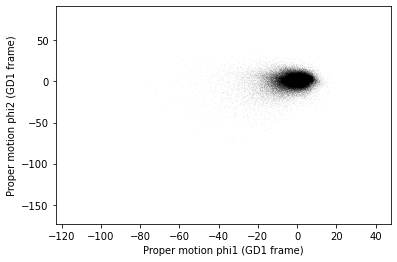

In [38]:
x = results_df['pm_phi1']
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)
    
plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)');

Most of the proper motions are near the origin, but there are a few extreme values.

Following the example in the paper, we'll use `xlim` and `ylim` to zoom in on the region near the origin.

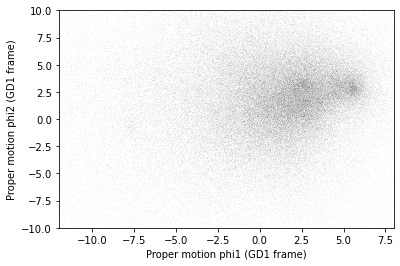

In [39]:
x = results_df['pm_phi1']
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)
    
plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10);

There is a hint of an overdense region near (-7.5, 0), but if you didn't know where to look, you would miss it.

To see the cluster more clearly, we need a sample that contains a higher proportion of stars in GD-1.

We'll do that by selecting stars close to the centerline.

## Selecting the centerline

As we can see in the following figure, many stars in GD-1 are less than 1 degree from the line `phi2=0`.

<img src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-4.png">

Stars near this line have the highest probability of being in GD-1.

To select them, we will use a "Boolean mask".  We'll start by selecting the `phi2` column from the `DataFrame`:

In [46]:
phi2 = results_df['phi2']
type(phi2)

pandas.core.series.Series

The result is a `Series`, which is the structure Pandas uses to represent columns.

We can use a comparison operator, `>`, to compare the values in a `Series` to a constant.

In [47]:
phi2_min = -1.0 * u.degree
phi2_max = 1.0 * u.degree

mask = (phi2 > phi2_min)
type(mask)

pandas.core.series.Series

The result is a `Series` of Boolean values, that is, `True` and `False`. 

In [48]:
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: phi2, dtype: bool

The `&` operator computes "logical AND", which means the result is true where elements from both Boolean `Series` are true.

In [49]:
mask = (phi2 > phi2_min) & (phi2 < phi2_max)

**Python detail:** We need the parentheses around the conditions; otherwise the order of operations is incorrect.

Also, Python's logical operators (`and`, `or`, and `not`) don't work with NumPy or Pandas.  Both libraries use the bitwise operators (`&`, `|`, and `~`) to do elementwise logical operations [explanation here](https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas).

The sum of a Boolean `Series` is the number of `True` values, so we can use `sum` to see how many stars are in the selected region.

In [50]:
mask.sum()

25084

A Boolean `Series` is sometimes called a "mask" because we can use it to mask out some of the rows in a `DataFrame` and select the rest, like this:

In [51]:
centerline_df = results_df[mask]
type(centerline_df)

pandas.core.frame.DataFrame

`centerline_df` is a `DataFrame` that contains only the rows from `results_df` that correspond to `True` values in `mask`; that is, in contains the stars near the centerline of GD-1.

We can use `len` to see how many rows are in `centerline_df`:

In [52]:
len(centerline_df)

25084

And what fraction of the rows we've selected.

In [53]:
len(centerline_df) / len(results_df)

0.1787386257562046

There are about 25,000 stars in this region, about 18% of the total.

## Plotting proper motion

Since we've plotted proper motion several times, let's put that code in a function.

In [54]:
def plot_proper_motion(df):
    """Plot proper motion.
    
    df: DataFrame with `pm_phi1` and `pm_phi2`
    """
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
    plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

    plt.xlim(-12, 8)
    plt.ylim(-10, 10)

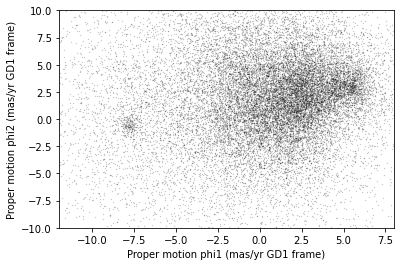

In [55]:
plot_proper_motion(centerline_df)

Now we can see more clearly that there is a cluster near (-7.5, 0).

You might notice that our figure is less dense than the one in the paper.  That's because we started with a set of stars from a relatively small region.  The figure in the paper is based on a region about 10 times bigger.

In the next lesson we'll go back and select stars from a larger region.  But first we'll use the proper motion data to identify stars likely to be in GD-1.

## Filtering based on proper motion

The next step is to select stars in the "overdense" region of proper motion, which are candidates to be in GD-1.

In the original paper, Price-Whelan and Bonaca used a polygon to cover this region, as shown in this figure.

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-1.png">

We'll use a simple rectangle for now, but in a later lesson we'll see how to select a polygonal region as well.

Here are bounds on proper motion we chose by eye:

In [56]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

To draw these bounds, we'll use `make_rectangle` to make two lists containing the coordinates of the corners of the rectangle.

In [57]:
def make_rectangle(x1, x2, y1, y2):
    """Return the corners of a rectangle."""
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    return xs, ys

In [58]:
pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)

Here's what the plot looks like with the bounds we chose.

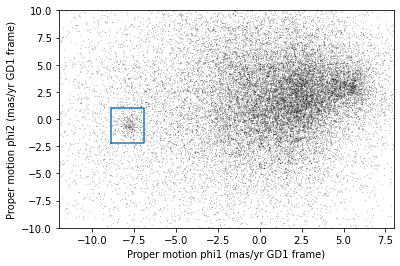

In [59]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect, '-');

Now that we've identified the bounds of the cluster in proper motion, we'll use it to select rows from `results_df`.

We'll use the following function, which uses Pandas operators to make a mask that selects rows where `series` falls between `low` and `high`.

In [60]:
def between(series, low, high):
    """Check whether values are between `low` and `high`."""
    return (series > low) & (series < high)

The following mask selects stars with proper motion in the region we chose.

In [61]:
pm1 = results_df['pm_phi1']
pm2 = results_df['pm_phi2']

pm_mask = (between(pm1, pm1_min, pm1_max) & 
           between(pm2, pm2_min, pm2_max))

Again, the sum of a Boolean series is the number of `True` values.

In [62]:
pm_mask.sum()

1049

Now we can use this mask to select rows from `results_df`.

In [63]:
selected_df = results_df[pm_mask]
len(selected_df)

1049

These are the stars we think are likely to be in GD-1.  Let's see what they look like, plotting their coordinates (not their proper motion).

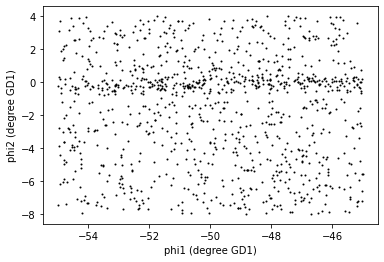

In [64]:
x = selected_df['phi1']
y = selected_df['phi2']
plt.plot(x, y, 'ko', markersize=1, alpha=1)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)');

Now that's starting to look like a tidal stream!

## Saving the DataFrame

At this point we have run a successful query and cleaned up the results; this is a good time to save the data.

To save a Pandas `DataFrame`, one option is to convert it to an Astropy `Table`, like this:

In [91]:
selected_table = Table.from_pandas(selected_df)
type(selected_table)

astropy.table.table.Table

Then we could write the `Table` to a FITS file, as we did in the previous lesson.  

But Pandas provides functions to write DataFrames in other formats; to see what they are [find the functions here that begin with `to_`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

One of the best options is HDF5, which is Version 5 of [Hierarchical Data Format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format).

HDF5 is a binary format, so files are small and fast to read and write (like FITS, but unlike XML).

An HDF5 file is similar to an SQL database in the sense that it can contain more than one table, although in HDF5 vocabulary, a table is called a Dataset.  ([Multi-extension FITS files](https://www.stsci.edu/itt/review/dhb_2011/Intro/intro_ch23.html) can also contain more than one table.)

And HDF5 stores the metadata associated with the table, including column names, row labels, and data types (like FITS).

Finally, HDF5 is a cross-language standard, so if you write an HDF5 file with Pandas, you can read it back with many other software tools (more than FITS).

We can write a Pandas `DataFrame` to an HDF5 file like this:

In [92]:
filename = 'gd1_data.hdf'

selected_df.to_hdf(filename, 'selected_df', mode='w')

Because an HDF5 file can contain more than one Dataset, we have to provide a name, or "key", that identifies the Dataset in the file.

We could use any string as the key, but it will be convenient to give the Dataset in the file the same name as the `DataFrame`.

The argument `mode='w'` means that if the file already exists, we should overwrite it.

### Exercise 

We're going to need `centerline_df` later as well.  Write a line of code to add it as a second Dataset in the HDF5 file.

Hint: Since the file already exists, you should *not* use `mode='w'`.

In [94]:
# Solution

centerline_df.to_hdf(filename, 'centerline_df')

We can use `ls` to confirm that the file exists and check the size:

In [95]:
!ls -lh gd1_data.hdf

-rw-rw-r-- 1 downey downey 2.7M Jan  9 17:25 gd1_data.hdf


If you are using Windows, `ls` might not work; in that case, try:

```
!dir gd1_data.hdf
```

We can read the file back like this:

If you forget what the names of the Datasets in the file are, you can read them back like this:

In [96]:
with pd.HDFStore(filename) as hdf:
    print(hdf.keys())

['/centerline_df', '/selected_df']


The keys are the names of the Datasets.  Notice that they start with `/`, which indicates that they are at the top level of the Dataset hierarchy, and not in a named "group".

In future lessons we will add a few more Datasets to this file, but not so many that we need to organize them into groups.

## Summary

In this lesson, we re-loaded the Gaia data we saved from a previous query.

We transformed the coordinates and proper motion from ICRS to a frame aligned with the orbit of GD-1, and stored the results in a Pandas `DataFrame`.

Then we replicated the selection process from the Price-Whelan and Bonaca paper:

* We selected stars near the centerline of GD-1 and made a scatter plot of their proper motion.

* We identified a region of proper motion that contains stars likely to be in GD-1.

* We used a Boolean `Series` as a mask to select stars whose proper motion is in that region.

So far, we have used data from a relatively small region of the sky.  In the next lesson, we'll write a query that selects stars based on proper motion, which will allow us to explore a larger region.

## Best practices

* When you make a scatter plot, adjust the size of the markers and their transparency so the figure is not overplotted; otherwise it can misrepresent the data badly.

* For simple scatter plots in Matplotlib, `plot` is faster than `scatter`.

* An Astropy `Table` and a Pandas `DataFrame` are similar in many ways and they provide many of the same functions.  They have pros and cons, but for many projects, either one would be a reasonable choice.

* To store data from a Pandas `DataFrame`, a good option is an HDF file, which can contain multiple Datasets.